In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pylab as plt

import sys
sys.path.append("../")
import numpy as np

In [2]:
import colorterms

In [3]:
colorterms.load_catalogs(path='../catalogs')

In [4]:
lbda = colorterms.CATALOGS['gunnstryker'][1]['lbda']
flux = colorterms.CATALOGS['gunnstryker'][1]['flux']

In [5]:
spec = colorterms.Spectrum(lbda, flux, fpath="../filtersets")

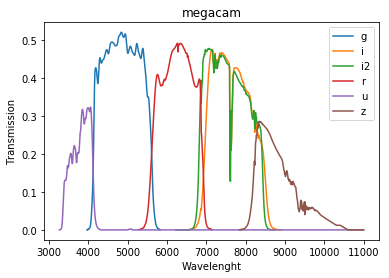

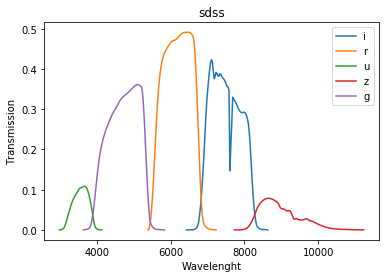

In [6]:
spec.filters.plot_filters()

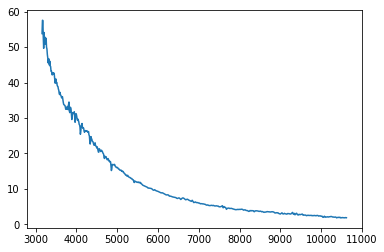

In [7]:
plt.plot(lbda, flux)

In [8]:
min(lbda), max(lbda)

(3160.0, 10620.0)

In [9]:
spec.filters.ordered

{'megacam': array(['u', 'g', 'r', 'i2', 'i', 'z'],
       dtype='|S2'), 'sdss': array(['u', 'g', 'r', 'i', 'z'],
       dtype='|S1')}

In [10]:
magMega = spec.mag(syst='megacam', filt='g')
magSDSS = spec.mag(syst='sdss', filt='g')
print(magMega, magSDSS)

((-38.67289197460465, None), (-38.19759506605211, None))


In [11]:
# shortcut
cat = colorterms.CATALOGS['gunnstryker']
magMega = [cat[i]['spec'].mag(syst='megacam', filt='g')[0] for i in cat]
magSDSS = [cat[i]['spec'].mag(syst='sdss', filt='g')[0] for i in cat]

In [12]:
mags = {}
for syst in spec.filters.filters:
    mags[syst] = {}
    for filt in spec.filters.filters[syst]:
        mags[syst][filt] = np.array([cat[i]['spec'].mag(syst=syst, filt=filt)[0] for i in cat])

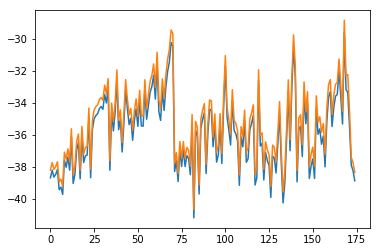

In [13]:
x = np.arange(len(colorterms.CATALOGS['gunnstryker']))
plt.plot(x, magMega, x, magSDSS)

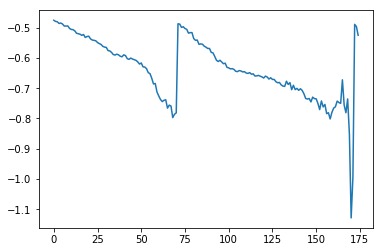

In [14]:
plt.plot(x, np.asarray(magMega)-np.asarray(magSDSS))

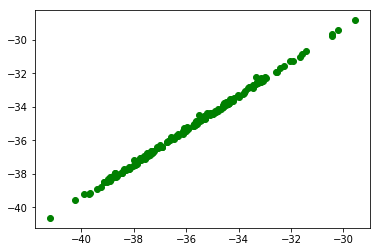

In [15]:
plt.plot(mags['megacam']['g'], mags['sdss']['g'], 'og')

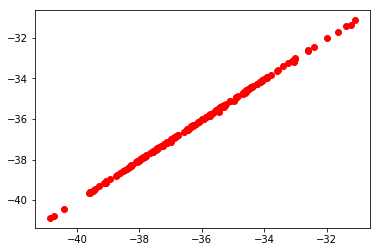

In [16]:
plt.plot(mags['sdss']['r'], mags['megacam']['r'] + 0.011 * (mags['megacam']['g'] - mags['megacam']['r']), 'or')

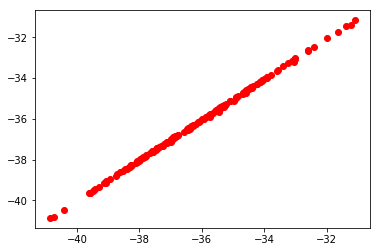

In [17]:
plt.plot(mags['sdss']['r'], mags['megacam']['r'], 'or')

(array([ 29.,  24.,  24.,  40.,  27.,  20.,   6.,   3.,   0.,   2.]),
 array([-0.00839028, -0.00475241, -0.00111454,  0.00252333,  0.0061612 ,
         0.00979907,  0.01343694,  0.01707481,  0.02071268,  0.02435055,
         0.02798841]),
 <a list of 10 Patch objects>)

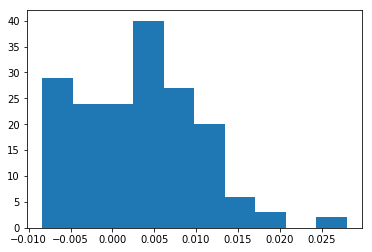

In [18]:
plt.hist(0.011 * (mags['megacam']['g'] - mags['megacam']['r']))

In [19]:
from scipy.optimize import minimize

In [35]:
def lin(params, f0=None, f1=None, f2=None):
    return sum((f0 - f1 - params[0] * f2) ** 2)

def square(params, f0=None, f1=None, f2=None):
    return sum((f0 - f1 - params[0] * f2 - params[1] * f2 ** 2) ** 2)

In [36]:
#m0 = mags['sdss']['r']
#m1 = mags['megacam']['r']
#c1 = mags['megacam']['g'] - mags['megacam']['r']
m0 = mags['megacam']['r']
m1 = mags['sdss']['r']
c1 = mags['sdss']['g'] - mags['sdss']['r']

In [41]:
out = minimize(lin, (0.), args=(m0, m1, c1))
print out

      fun: 0.05015317115607986
 hess_inv: array([[1]])
      jac: array([  5.74160367e-07])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.04766993])


In [42]:
out2 = minimize(square, (0., 0.), args=(mags['sdss']['r'], mags['megacam']['r'], mags['megacam']['g'] - mags['megacam']['r']))
print out

      fun: 0.05015317115607986
 hess_inv: array([[1]])
      jac: array([  5.74160367e-07])
  message: 'Optimization terminated successfully.'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([-0.04766993])


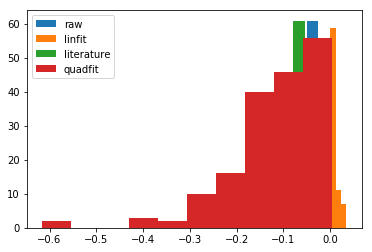

In [43]:
plt.hist(m0 - m1, label='raw')
plt.hist(m0 - m1 - out.x[0] * c1, label='linfit')
plt.hist(m0 - m1 - 0.011 * c1, label='literature')
plt.hist(m0 - m1 - out2.x[0] * c1 - out2.x[1] * c1 ** 2, label='quadfit')
plt.legend(loc='best')

In [44]:
def mean_std(x): 
    return np.mean(x), np.std(x)

In [45]:
print('raw', mean_std(m0 - m1))
print('linfit', mean_std(m0 - m1 - out.x[0] * c1))
print('literature', mean_std(m0 - m1 - 0.011 * c1))
print('quadfit', mean_std(m0 - m1 - out2.x[0] * c1 - out2.x[1] * c1 ** 2))

('raw', (-0.046146722511596502, 0.034071082811279366))
('linfit', (-0.003262299221178573, 0.016611651129698431))
('literature', (-0.056042451037271908, 0.041180151891958984))
('quadfit', (-0.1156153069930526, 0.10199660548931185))


In [46]:
from scipy import polyfit, polyval

In [47]:
p1 = polyfit(c1, m0 - m1, 1)
p2 = polyfit(c1, m0 - m1, 2)
p3 = polyfit(c1, m0 - m1, 3)
print(p1)
print(p2)
print(p3)

[-0.04194386 -0.00841354]
[-0.00961909 -0.02170256 -0.01390799]
[ 0.0016634  -0.01648966 -0.01544848 -0.01422448]


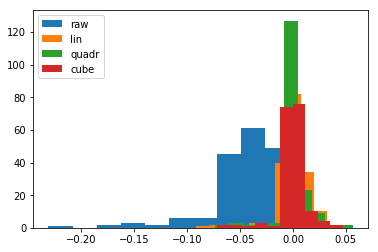

In [48]:
plt.hist(m0 - m1, label='raw')
plt.hist(m0 - m1 - polyval(p1, c1), label='lin')
plt.hist(m0 - m1 - polyval(p2, c1), label='quadr')
plt.hist(m0 - m1 - polyval(p3, c1), label='cube')
plt.legend(loc='best')

In [30]:
print('raw',  mean_std(m0 - m1))
print('lin',  mean_std(m0 - m1 - polyval(p1, c1)))
print('quad', mean_std(m0 - m1 - polyval(p2, c1)))
print('cube', mean_std(m0 - m1 - polyval(p3, c1)))

('raw', (0.046146722511596502, 0.034071082811279366))
('lin', (-1.6653345369377347e-17, 0.014782894556538129))
('quad', (8.2473710400725917e-18, 0.012131954347138232))
('cube', (1.5067312477055695e-17, 0.012130895358316933))
